Looking for data in: D:\School Stuff\Pradita University\SEM 5\MLDL\Pre-Apnea-Prediction\data\HuGCDN2014-OXI
Directory exists: True
Contents: [WindowsPath('D:/School Stuff/Pradita University/SEM 5/MLDL/Pre-Apnea-Prediction/data/HuGCDN2014-OXI/LABELS'), WindowsPath('D:/School Stuff/Pradita University/SEM 5/MLDL/Pre-Apnea-Prediction/data/HuGCDN2014-OXI/RR'), WindowsPath('D:/School Stuff/Pradita University/SEM 5/MLDL/Pre-Apnea-Prediction/data/HuGCDN2014-OXI/SAT')]
HuGCDN SpO2 EDA for MAX30102 Pre-Apnea Detection

🔍 DEBUGGING PATH ISSUES:
BASE_DIR: D:\School Stuff\Pradita University\SEM 5\MLDL\Pre-Apnea-Prediction
  Exists? True

DATA_DIR: D:\School Stuff\Pradita University\SEM 5\MLDL\Pre-Apnea-Prediction\data
  Exists? True
  Contents: ['HuGCDN2014-OXI', 'st-vincents-university-hospital-university-college-dublin-sleep-apnea-database-1.0.0']

HUGCDN_DIR: D:\School Stuff\Pradita University\SEM 5\MLDL\Pre-Apnea-Prediction\data\HuGCDN2014-OXI
  Exists? True

  HuGCDN subdirectories:
    - LABE

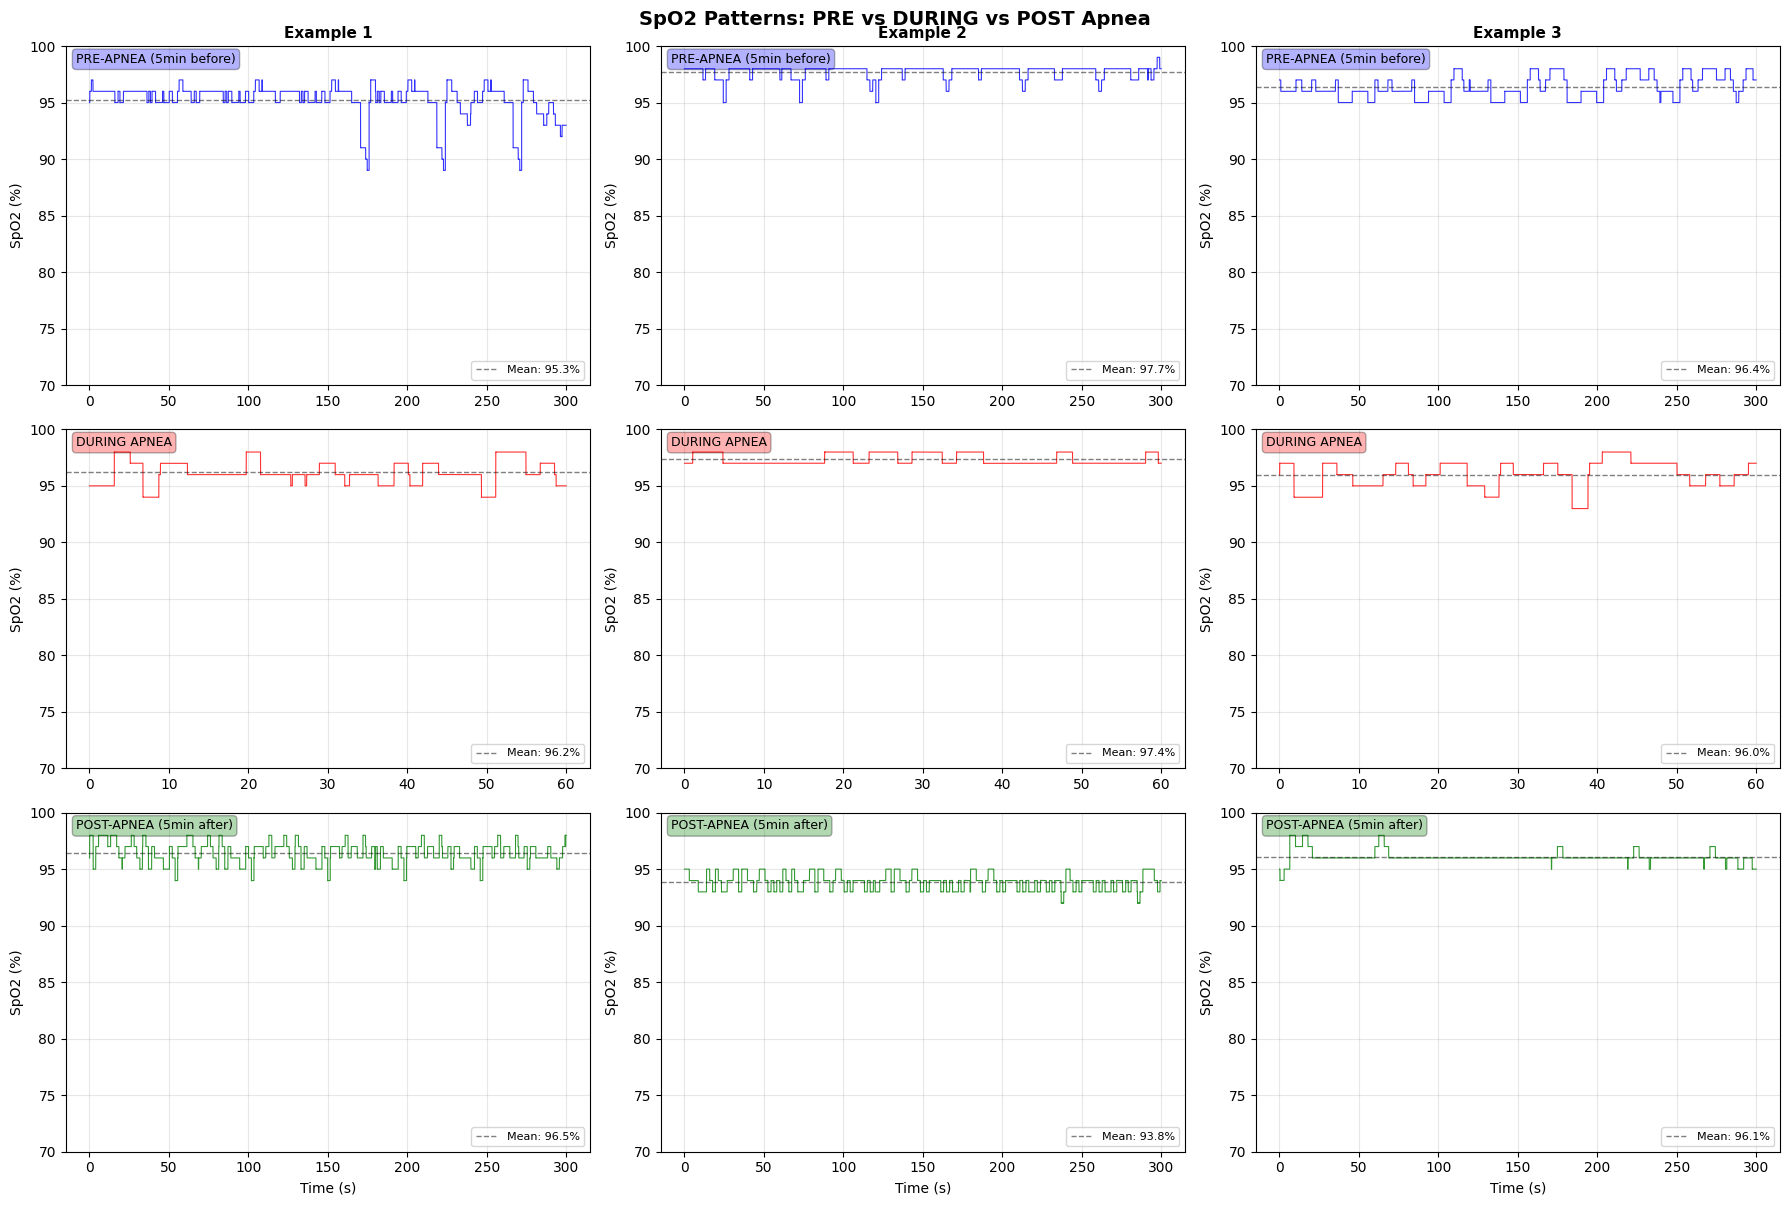


✓ EDA COMPLETE!

Next steps:
1. Review SpO2 pattern plots - do PRE patterns look different?
2. Check feature statistics - which features discriminate best?
3. Adjust your ESP32 code buffer size based on recommendations
4. Consider experimenting with different prediction horizons


In [5]:
"""
HuGCDN2014-OXI EDA for MAX30102 SpO2 Pre-Apnea Detection

Analyzes:
- SpO2 patterns in PRE-APNEA vs DURING vs POST-APNEA windows
- Optimal window size for MAX30102 sampling
- Feature extraction from SpO2 time series
- Timing analysis: how far ahead can we predict?
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pathlib import Path
from scipy.stats import kurtosis, skew
from scipy.signal import find_peaks
import pandas as pd

# =============================================================================
# CONFIGURATION
# =============================================================================
# CHANGE THIS TO YOUR ACTUAL PATH!
BASE_DIR = Path(r"D:\School Stuff\Pradita University\SEM 5\MLDL\Pre-Apnea-Prediction")
DATA_DIR = BASE_DIR / "data"
HUGCDN_DIR = DATA_DIR / "HuGCDN2014-OXI"

print(f"Looking for data in: {HUGCDN_DIR}")
print(f"Directory exists: {HUGCDN_DIR.exists()}")

if HUGCDN_DIR.exists():
    print(f"Contents: {list(HUGCDN_DIR.iterdir())}")
else:
    print("ERROR: Directory does not exist!")
    print(f"Please check your path. Current BASE_DIR: {BASE_DIR}")

# Sampling parameters
EPOCH_DURATION = 60  # seconds per epoch (1 minute)
MAX30102_SAMPLE_RATE = 50  # Hz (from your code)

# =============================================================================
# DATA LOADING FUNCTIONS (from your code)
# =============================================================================

def load_labels(path: Path) -> np.ndarray:
    """Load per-minute labels from LABELS/*.mat"""
    d = loadmat(str(path))
    if "salida_man_1m" in d:
        raw = d["salida_man_1m"]
    elif "salida_man" in d:
        raw = d["salida_man"]
    else:
        keys = [k for k in d.keys() if not k.startswith("__")]
        raw = d[keys[0]]
    labels = np.ravel(raw).astype(int)
    return labels


def extract_epoch_series(raw) -> list:
    """Convert MATLAB cell/numeric array into list of 1D arrays"""
    arr = np.array(raw)
    
    if arr.dtype == object:
        epochs = []
        for x in arr.ravel():
            x = np.array(x).astype(float).ravel()
            if x.size > 0:
                epochs.append(x)
        return epochs
    
    arr = np.squeeze(arr)
    if arr.ndim == 1:
        return [arr.astype(float)]
    else:
        return [arr[i, :].astype(float).ravel() for i in range(arr.shape[0])]


def load_sat_epochs(path: Path) -> list:
    """Load SpO2 epochs"""
    d = loadmat(str(path))
    for name in ["sat", "Sat", "SaO2", "satO2", "SaO2_1m"]:
        if name in d:
            raw = d[name]
            break
    else:
        keys = [k for k in d.keys() if not k.startswith("__")]
        raw = d[keys[0]]
    return extract_epoch_series(raw)


def resize_epoch(x: np.ndarray, target_len: int) -> np.ndarray:
    """Linearly resample 1D array to fixed length"""
    x = np.asarray(x, dtype=float).ravel()
    if x.size == 0:
        return np.zeros(target_len, dtype=float)
    if x.size == target_len:
        return x
    old_idx = np.linspace(0.0, 1.0, num=x.size)
    new_idx = np.linspace(0.0, 1.0, num=target_len)
    return np.interp(new_idx, old_idx, x)


# =============================================================================
# WINDOW EXTRACTION
# =============================================================================

def extract_windows_around_apnea(sat_epochs, labels, pre_minutes=5, post_minutes=5):
    """
    Extract PRE, DURING, and POST apnea windows
    
    Parameters:
    - sat_epochs: list of SpO2 arrays (one per minute)
    - labels: array of 0/1 labels per minute
    - pre_minutes: how many minutes before apnea to extract
    - post_minutes: how many minutes after apnea to extract
    
    Returns:
    - windows dict with 'pre', 'during', 'post' keys
    """
    
    n_epochs = min(len(sat_epochs), len(labels))
    labels = labels[:n_epochs]
    
    windows = {
        'pre': [],
        'during': [],
        'post': []
    }
    
    # Find apnea events
    i = 0
    while i < len(labels):
        if labels[i] == 1:
            # Found apnea start
            apnea_start = i
            
            # Find apnea end
            apnea_end = i
            while apnea_end < len(labels) and labels[apnea_end] == 1:
                apnea_end += 1
            
            # Extract PRE window (before apnea)
            pre_start = max(0, apnea_start - pre_minutes)
            if pre_start < apnea_start:
                pre_window = sat_epochs[pre_start:apnea_start]
                if len(pre_window) > 0:
                    windows['pre'].append({
                        'data': pre_window,
                        'start_idx': pre_start,
                        'duration': len(pre_window)
                    })
            
            # Extract DURING window
            during_window = sat_epochs[apnea_start:apnea_end]
            if len(during_window) > 0:
                windows['during'].append({
                    'data': during_window,
                    'start_idx': apnea_start,
                    'duration': len(during_window)
                })
            
            # Extract POST window (after apnea)
            post_end = min(len(sat_epochs), apnea_end + post_minutes)
            if apnea_end < post_end:
                post_window = sat_epochs[apnea_end:post_end]
                if len(post_window) > 0:
                    windows['post'].append({
                        'data': post_window,
                        'start_idx': apnea_end,
                        'duration': len(post_window)
                    })
            
            # Skip to end of this apnea event
            i = apnea_end
        else:
            i += 1
    
    return windows


# =============================================================================
# FEATURE EXTRACTION FROM SPO2
# =============================================================================

def extract_spo2_features(spo2_array):
    """Extract features from SpO2 time series (single epoch or concatenated)"""
    
    features = {}
    
    if len(spo2_array) < 5:
        return {k: 0 for k in ['mean', 'std', 'min', 'max', 'range', 
                               'desaturation_events', 'desaturation_depth',
                               'variability', 'slope', 'kurtosis', 'skewness']}
    
    # Basic statistics
    features['mean'] = np.mean(spo2_array)
    features['std'] = np.std(spo2_array)
    features['min'] = np.min(spo2_array)
    features['max'] = np.max(spo2_array)
    features['range'] = features['max'] - features['min']
    
    # Desaturation events (drops > 3% from local baseline)
    baseline = np.mean(spo2_array[:len(spo2_array)//3]) if len(spo2_array) > 3 else features['mean']
    desaturations = np.sum(spo2_array < (baseline - 3))
    features['desaturation_events'] = desaturations
    
    # Maximum desaturation depth
    features['desaturation_depth'] = baseline - features['min']
    
    # Variability (coefficient of variation)
    features['variability'] = features['std'] / (features['mean'] + 1e-6)
    
    # Trend (linear slope)
    x = np.arange(len(spo2_array))
    slope = np.polyfit(x, spo2_array, 1)[0] if len(spo2_array) > 1 else 0
    features['slope'] = slope
    
    # Higher order statistics
    features['kurtosis'] = kurtosis(spo2_array)
    features['skewness'] = skew(spo2_array)
    
    return features


# =============================================================================
# MAIN EDA
# =============================================================================

def main():
    print("="*80)
    print("HuGCDN SpO2 EDA for MAX30102 Pre-Apnea Detection")
    print("="*80)
    print()
    
    # DEBUG: Check directory structure
    print("🔍 DEBUGGING PATH ISSUES:")
    print(f"BASE_DIR: {BASE_DIR}")
    print(f"  Exists? {BASE_DIR.exists()}")
    
    print(f"\nDATA_DIR: {DATA_DIR}")
    print(f"  Exists? {DATA_DIR.exists()}")
    
    if DATA_DIR.exists():
        print(f"  Contents: {[d.name for d in DATA_DIR.iterdir()]}")
    
    print(f"\nHUGCDN_DIR: {HUGCDN_DIR}")
    print(f"  Exists? {HUGCDN_DIR.exists()}")
    
    if not HUGCDN_DIR.exists():
        print("\n❌ ERROR: HuGCDN directory not found!")
        print("\nPlease update the BASE_DIR path in the script to match your folder structure.")
        print("Based on your file tree image, it should be something like:")
        print('  BASE_DIR = Path(r"D:\\school\\uni\\sem 5\\MLDL\\TinyML UAS\\src")')
        print('  or wherever your "data/HuGCDN2014-OXI" folder is located')
        return
    
    print(f"\n  HuGCDN subdirectories:")
    for item in HUGCDN_DIR.iterdir():
        print(f"    - {item.name}")
    
    # Find all subjects
    label_dir = HUGCDN_DIR / "LABELS"
    
    print(f"\nLABELS directory: {label_dir}")
    print(f"  Exists? {label_dir.exists()}")
    
    if not label_dir.exists():
        print("\n❌ ERROR: LABELS directory not found inside HuGCDN!")
        print(f"Expected: {label_dir}")
        return
    
    # List .mat files
    mat_files = list(label_dir.glob("*.mat"))
    print(f"\n  Found {len(mat_files)} .mat files in LABELS/")
    
    if len(mat_files) == 0:
        print("\n❌ ERROR: No .mat files found in LABELS directory!")
        print("Please check if:")
        print("  1. The files are actually there")
        print("  2. They have .mat extension (not .MAT or something else)")
        return
    
    print(f"  First 5 files: {[f.name for f in mat_files[:5]]}")
    
    subject_ids = sorted([f.stem for f in mat_files])
    
    print(f"\nFound {len(subject_ids)} subjects")
    print()
    
    # Storage for all windows
    all_pre_windows = []
    all_during_windows = []
    all_post_windows = []
    
    apnea_durations = []
    subject_apnea_counts = []
    
    # Process each subject
    for sid in subject_ids[:10]:  # Process first 10 for speed
        print(f"Processing {sid}...", end=" ")
        
        try:
            label_path = HUGCDN_DIR / "LABELS" / f"{sid}.mat"
            sat_path = HUGCDN_DIR / "SAT" / f"{sid}.mat"
            
            labels = load_labels(label_path)
            sat_epochs = load_sat_epochs(sat_path)
            
            # Extract windows
            windows = extract_windows_around_apnea(
                sat_epochs, labels, 
                pre_minutes=5, 
                post_minutes=5
            )
            
            all_pre_windows.extend(windows['pre'])
            all_during_windows.extend(windows['during'])
            all_post_windows.extend(windows['post'])
            
            # Count apnea events
            n_apnea = len(windows['during'])
            subject_apnea_counts.append(n_apnea)
            
            # Track apnea durations
            for w in windows['during']:
                apnea_durations.append(w['duration'])
            
            print(f"✓ {n_apnea} apnea events, "
                  f"{len(windows['pre'])} pre-windows, "
                  f"{len(windows['post'])} post-windows")
            
        except Exception as e:
            print(f"✗ Error: {e}")
    
    print()
    print(f"{'='*80}")
    print(f"DATASET SUMMARY")
    print(f"{'='*80}")
    print(f"Total PRE-apnea windows:    {len(all_pre_windows)}")
    print(f"Total DURING-apnea windows: {len(all_during_windows)}")
    print(f"Total POST-apnea windows:   {len(all_post_windows)}")
    print()
    
    if len(apnea_durations) > 0:
        print(f"Apnea Duration Statistics (minutes):")
        print(f"  Mean:   {np.mean(apnea_durations):.1f}")
        print(f"  Median: {np.median(apnea_durations):.1f}")
        print(f"  Min:    {np.min(apnea_durations)}")
        print(f"  Max:    {np.max(apnea_durations)}")
        print()
    
    # ==========================================================================
    # ANALYSIS 1: SpO2 PATTERNS VISUALIZATION
    # ==========================================================================
    
    print("Generating SpO2 pattern visualizations...")
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    
    # Plot sample windows from each type
    window_types = [
        ('PRE-APNEA (5min before)', all_pre_windows, 'blue'),
        ('DURING APNEA', all_during_windows, 'red'),
        ('POST-APNEA (5min after)', all_post_windows, 'green')
    ]
    
    for row, (title, windows, color) in enumerate(window_types):
        if len(windows) == 0:
            continue
        
        # Plot 3 random examples
        sample_indices = np.random.choice(len(windows), min(3, len(windows)), replace=False)
        
        for col, idx in enumerate(sample_indices):
            ax = axes[row, col]
            
            window = windows[idx]
            epochs = window['data']
            
            # Concatenate all epochs in this window
            spo2_values = []
            for epoch in epochs:
                spo2_values.extend(epoch)
            
            time_axis = np.arange(len(spo2_values)) / (len(spo2_values) / (len(epochs) * 60))
            
            ax.plot(time_axis, spo2_values, color=color, linewidth=0.8, alpha=0.8)
            ax.set_ylabel('SpO2 (%)', fontsize=10)
            ax.set_ylim(70, 100)
            ax.grid(True, alpha=0.3)
            
            if row == 0:
                ax.set_title(f'Example {col+1}', fontsize=11, fontweight='bold')
            if row == 2:
                ax.set_xlabel('Time (s)', fontsize=10)
            
            # Add window type label
            ax.text(0.02, 0.98, title, transform=ax.transAxes,
                   fontsize=9, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))
            
            # Mark mean line
            mean_spo2 = np.mean(spo2_values)
            ax.axhline(mean_spo2, color='black', linestyle='--', 
                      linewidth=1, alpha=0.5, label=f'Mean: {mean_spo2:.1f}%')
            ax.legend(loc='lower right', fontsize=8)
    
    plt.tight_layout()
    fig.suptitle('SpO2 Patterns: PRE vs DURING vs POST Apnea', 
                fontsize=14, fontweight='bold', y=1.00)
    plt.subplots_adjust(top=0.97)
    
    # ==========================================================================
    # ANALYSIS 2: FEATURE COMPARISON
    # ==========================================================================
    
    print("Extracting features from windows...")
    
    pre_features = []
    during_features = []
    post_features = []
    
    for window in all_pre_windows[:50]:  # Sample for speed
        epochs = window['data']
        spo2_concat = np.concatenate([np.array(e) for e in epochs])
        pre_features.append(extract_spo2_features(spo2_concat))
    
    for window in all_during_windows[:50]:
        epochs = window['data']
        spo2_concat = np.concatenate([np.array(e) for e in epochs])
        during_features.append(extract_spo2_features(spo2_concat))
    
    for window in all_post_windows[:50]:
        epochs = window['data']
        spo2_concat = np.concatenate([np.array(e) for e in epochs])
        post_features.append(extract_spo2_features(spo2_concat))
    
    # Convert to DataFrame
    df_pre = pd.DataFrame(pre_features)
    df_during = pd.DataFrame(during_features)
    df_post = pd.DataFrame(post_features)
    
    print()
    print(f"{'='*80}")
    print(f"FEATURE STATISTICS")
    print(f"{'='*80}")
    
    key_features = ['mean', 'std', 'min', 'desaturation_events', 
                    'desaturation_depth', 'variability']
    
    for feat in key_features:
        if feat in df_pre.columns:
            pre_mean = df_pre[feat].mean()
            during_mean = df_during[feat].mean()
            post_mean = df_post[feat].mean()
            
            print(f"\n{feat.upper()}:")
            print(f"  PRE-APNEA:  {pre_mean:8.3f}")
            print(f"  DURING:     {during_mean:8.3f} ({(during_mean-pre_mean)/pre_mean*100:+.1f}% change)")
            print(f"  POST:       {post_mean:8.3f} ({(post_mean-pre_mean)/pre_mean*100:+.1f}% change)")
    
    # ==========================================================================
    # ANALYSIS 3: OPTIMAL WINDOW SIZE FOR MAX30102
    # ==========================================================================
    
    print()
    print(f"\n{'='*80}")
    print(f"MAX30102 SAMPLING RECOMMENDATIONS")
    print(f"{'='*80}")
    
    # Calculate samples per minute
    samples_per_minute = EPOCH_DURATION * MAX30102_SAMPLE_RATE
    print(f"\nMAX30102 Configuration:")
    print(f"  Sample Rate: {MAX30102_SAMPLE_RATE} Hz")
    print(f"  Samples per minute (epoch): {samples_per_minute}")
    
    # Recommended window sizes
    print(f"\nRecommended Window Sizes:")
    
    for minutes in [1, 2, 3, 5]:
        total_samples = minutes * samples_per_minute
        memory_kb = total_samples * 4 / 1024  # 4 bytes per float
        
        print(f"\n  {minutes}-minute window:")
        print(f"    Total samples: {total_samples}")
        print(f"    Memory needed: {memory_kb:.1f} KB")
        print(f"    Prediction horizon: {minutes} min ahead")
        
        if memory_kb < 10:
            feasibility = "✅ HIGHLY FEASIBLE"
        elif memory_kb < 20:
            feasibility = "⚠️ FEASIBLE (tight)"
        else:
            feasibility = "❌ TOO LARGE for ESP32"
        
        print(f"    {feasibility}")
    
    # Based on your training code (T=200)
    print(f"\n📊 YOUR CURRENT MODEL (T=200):")
    print(f"  Window length: 200 seconds = {200/60:.1f} minutes")
    print(f"  Samples: {200 * MAX30102_SAMPLE_RATE} @ {MAX30102_SAMPLE_RATE}Hz")
    print(f"  Memory: {200 * 4 / 1024:.1f} KB (very feasible!)")
    
    print(f"\n💡 RECOMMENDATION:")
    print(f"  → Use 3-5 minute windows (180-300 seconds)")
    print(f"  → Update prediction every 30-60 seconds (sliding window)")
    print(f"  → Sample at 50Hz from MAX30102 (as you're already doing)")
    print(f"  → Buffer: ~300 samples = 1.2 KB RAM")
    
    # ==========================================================================
    # ANALYSIS 4: PREDICTION HORIZON
    # ==========================================================================
    
    print()
    print(f"\n{'='*80}")
    print(f"PRE-APNEA DETECTION HORIZON ANALYSIS")
    print(f"{'='*80}")
    
    print(f"\nYour training code uses PRE_APNEA_HORIZON = 1 minute")
    print(f"This means: predict if apnea will occur in next 1 minute")
    print()
    print(f"Alternative horizons to consider:")
    
    for horizon in [1, 2, 3, 5]:
        samples_for_prediction = horizon * samples_per_minute
        
        print(f"\n  {horizon}-minute horizon:")
        print(f"    Window to analyze: 3-5 minutes of SpO2 data")
        print(f"    Prediction: 'Will apnea occur in next {horizon} min?'")
        
        if horizon == 1:
            print(f"    ✅ Current setting - good balance")
        elif horizon <= 2:
            print(f"    ⚠️ Still detectable, slightly lower accuracy expected")
        else:
            print(f"    ❌ May be too far ahead - SpO2 patterns weaker")
    
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"✓ EDA COMPLETE!")
    print(f"{'='*80}")
    print(f"\nNext steps:")
    print(f"1. Review SpO2 pattern plots - do PRE patterns look different?")
    print(f"2. Check feature statistics - which features discriminate best?")
    print(f"3. Adjust your ESP32 code buffer size based on recommendations")
    print(f"4. Consider experimenting with different prediction horizons")


if __name__ == "__main__":
    main()